In [1]:
# MO444-A 2s/2017 - First assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Plotting inline instead of opening an outer window.
%matplotlib inline

# Imports
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

# Defines
years = range(1922, 2011)
random_state = np.random.RandomState(1)

# Functions
def load_data(filename):
    raw_data = open(filename, 'rt')
    data = np.loadtxt(raw_data, delimiter=",")
    return data

def split_Y_X(dataset):
    Y = dataset[:,0]
    X = dataset[:,1:]
    return Y, X

def get_errors_by_year(model, data_Y, data_X):
    errors = []
    for y in years:
        filt = data_Y == y
        if not sum(filt):
            errors.append(0)
            continue
        errors.append(mean_squared_error(data_Y[filt], model.predict(data_X[filt])))
    return errors

In [2]:
# load training data
data = load_data('year-prediction-msd-train.txt')

print('Training data size: {}'.format(len(data)))

Training data size: 463715


In [3]:
# Take a look at the data (5 first instances):
# - first column (index 0) is the song release year
# - remaining columns are the the features (indexes 1 - 90)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2004.0,46.50128,-18.37096,58.89824,27.28181,1.93097,-2.43167,18.64843,-5.62769,-1.47711,...,43.94716,-64.21148,13.04284,156.03785,-2.42670,51.71977,-43.56703,10.63735,24.08962,-21.41886
1,2005.0,41.46015,-52.30140,-4.59825,-19.28084,-11.85844,-19.54192,1.30306,-1.83185,5.98469,...,-13.48435,-154.65715,35.22429,89.53649,-3.13145,-128.28120,89.97277,-15.88139,-75.21074,-0.51139
2,2009.0,42.18667,-85.65863,-7.91506,-11.84193,-12.61959,-21.66749,4.97883,-11.86750,9.87342,...,42.08584,-181.77349,43.00181,87.94977,-13.70362,136.49979,140.32633,11.51422,382.79589,29.98269
3,1987.0,46.90244,19.86314,10.92119,4.87136,-41.17499,-19.84156,2.93308,-5.98711,3.05997,...,-2.76407,-20.31782,-75.24506,125.81801,-15.50828,-63.31002,-142.21937,-12.36699,32.45911,-17.14909
4,2009.0,46.64388,-81.99503,41.62851,3.65855,-9.38201,-13.51749,7.48781,-7.03302,7.06982,...,12.29244,-143.25348,91.15842,-227.85481,7.75916,-41.32376,-225.66526,-4.05081,455.39458,41.65310


In [4]:
# load test data
test_data = load_data('year-prediction-msd-test.txt')

print('Test data size: {}'.format(len(test_data)))

Test data size: 36285


In [5]:
# prepare for 5-fold execution to help avoiding overfitting
k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
data_Y, data_X = split_Y_X(data)

def run_kfold(method, data_Y, data_X, scale=False, partial_fit=False):
    train_msq_err, train_r2_score = [], []
    validation_msq_err, validation_r2_score = [], []
    start_time = datetime.now()
    k = 0
    print('k', end=' ')
    model = None
    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print(k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)
        
        if partial_fit:
            # feed the data partially
            n_chunks = 10
            chunk_size = len(train_data_Y) / n_chunks
            for i in range(0, n_chunks):
                range_start = i * chunk_size
                range_end = (i + 1) * chunk_size
                model = method(train_data_X[range_start:range_end], train_data_Y[range_start:range_end]) 
        else:
            model = method(train_data_X, train_data_Y)
        
        predicted_train_data_Y = model.predict(train_data_X)
        train_msq_err.append(sqrt(mean_squared_error(train_data_Y, predicted_train_data_Y)))
        train_r2_score.append(r2_score(train_data_Y, predicted_train_data_Y))
        
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_msq_err.append(sqrt(mean_squared_error(validation_data_Y, predicted_validation_data_Y)))
        validation_r2_score.append(r2_score(validation_data_Y, predicted_validation_data_Y))
    print('time elapsed: {}\n'.format(datetime.now() - start_time))
    print('                       RMSE         R2 Score')
    print('Training:    %5.2f sd %5.2f   %5.2f sd %5.2f' % (
                np.mean(train_msq_err), np.std(train_msq_err), np.mean(train_r2_score), np.std(train_r2_score)))
    print('Validation:  %5.2f sd %5.2f   %5.2f sd %5.2f' % (
                np.mean(validation_msq_err), np.std(validation_msq_err), np.mean(validation_r2_score), np.std(validation_r2_score)))
    return model

In [6]:
# Create a baseline linear regression model and train it
# LinearRegression implements the Ordinary Least Squares (OLS) method
lr_base_model = run_kfold(lambda X, Y: LinearRegression(copy_X=True).fit(X, Y), data_Y, data_X)

k 1 2 3 4 5 time elapsed: 0:00:23.312131

                       RMSE         R2 Score
Training:     9.55 sd  0.00    0.24 sd  0.00
Validation:   9.56 sd  0.02    0.24 sd  0.00


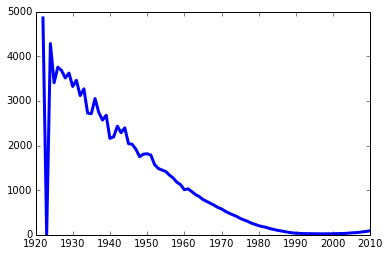

In [7]:
# plotting the errors vs years for the baseline model
errors = get_errors_by_year(lr_base_model, data_Y, data_X)
plt.plot(years, errors, color='blue', linewidth=3)
plt.show()

In [8]:
# LR-based alternative #1: LR with Stochastic Gradient Descent
lr_sgd_model = run_kfold(lambda X, Y: SGDRegressor(loss='squared_loss', penalty=None).fit(X, Y), data_Y, data_X, scale=True)

k 1 2 3 4 5 time elapsed: 0:00:13.562301

                       RMSE         R2 Score
Training:     9.65 sd  0.02    0.22 sd  0.00
Validation:   9.65 sd  0.05    0.22 sd  0.01


In [9]:
# LR-based alternative #2: LR with Mini-batch Gradient Descent
lr_mbgd_model = run_kfold(lambda X, Y: SGDRegressor(loss='squared_loss', penalty=None).partial_fit(X, Y), data_Y, data_X, scale=True, partial_fit=True)  

k 1 2 3 4 5 time elapsed: 0:00:09.266198

                       RMSE         R2 Score
Training:     9.89 sd  0.13    0.18 sd  0.02
Validation:   9.89 sd  0.18    0.18 sd  0.03


In [10]:
# LR-based alternative #3: LE with Batch Gradient Descent
lr_bgd_model = run_kfold(lambda X, Y: SGDRegressor(loss='squared_loss', penalty=None).partial_fit(X, Y), data_Y, data_X, scale=True, partial_fit=False)  

k 1 2 3 4 5 time elapsed: 0:00:09.536061

                       RMSE         R2 Score
Training:     9.66 sd  0.03    0.22 sd  0.00
Validation:   9.66 sd  0.03    0.22 sd  0.00


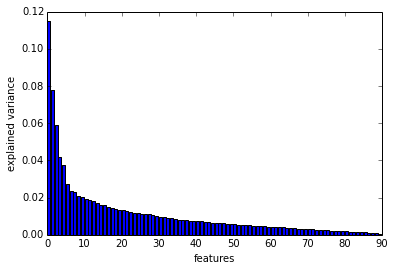

[ 0.11502467  0.07794225  0.05910869  0.04202648  0.03758654  0.02755601
  0.02360833  0.02314802  0.02099439  0.02018549  0.01921706  0.0185843
  0.01791093  0.01690428  0.01619226  0.01589057  0.01521183  0.01418454
  0.0140408   0.01350235  0.01312937  0.01257938  0.0123757   0.01183833
  0.0115447   0.01144419  0.01107826  0.0109434   0.01043585  0.01005587
  0.00980864  0.00941628  0.00926348  0.00894936  0.0084126   0.00819436
  0.00806348  0.00798967  0.00760238  0.00749503  0.00733399  0.00718305
  0.0069867   0.00681211  0.00660507  0.00635582  0.00626574  0.00616043
  0.00597297  0.00584532  0.00569058  0.00552105  0.0053618   0.00516686
  0.00502879  0.00499606  0.00487428  0.00472175  0.00462167  0.00439084
  0.00424316  0.00410322  0.00397162  0.00394916  0.00372014  0.00364846
  0.0035066   0.00336528  0.00325472  0.00316707  0.0030404   0.00292998
  0.00275516  0.00273829  0.00261313  0.00247287  0.0022838   0.00215105
  0.00209068  0.00204204  0.00188768  0.00175465  0.

In [11]:
# LR-based alternative #3: Feature reduction

# Principal component analysis (PCA)
pca_scaler = preprocessing.StandardScaler()
pca = PCA(n_components=90).fit(pca_scaler.fit_transform(data_X))
plt.bar(range(0, 90), pca.explained_variance_ratio_)
plt.xlabel('features')
plt.ylabel('explained variance')
plt.show()
print(pca.explained_variance_ratio_)

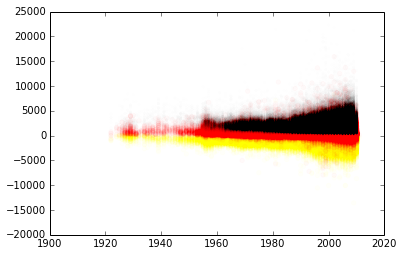

In [12]:
# First three PCA components plotted
transformed_data = pca.transform(data_X)
plt.scatter(data_Y, transformed_data[:,2], color='yellow', alpha=0.02)
plt.scatter(data_Y, transformed_data[:,1], color='red', alpha=0.02)
plt.scatter(data_Y, transformed_data[:,0], color='black', alpha=0.005)
plt.show()

In [13]:
for n_components in range(0, 91, 10):
    n_components = n_components or 1
    transformed_data_X = pca.transform(data_X)[:,range(0, n_components)]

    # Using the OLS model because it has shown the best fit so far.
    print('\n %2d PCA components used for OLS model:' % (n_components))
    lr_pca_base_model = run_kfold(lambda X, Y: LinearRegression(copy_X=True).fit(X, Y), data_Y, transformed_data_X)


  1 PCA components used for OLS model:
k 1 2 3 4 5 time elapsed: 0:00:00.475308

                       RMSE         R2 Score
Training:    10.94 sd  0.01    0.00 sd  0.00
Validation:  10.94 sd  0.03    0.00 sd  0.00

 10 PCA components used for OLS model:
k 1 2 3 4 5 time elapsed: 0:00:01.346234

                       RMSE         R2 Score
Training:    10.66 sd  0.01    0.05 sd  0.00
Validation:  10.66 sd  0.03    0.05 sd  0.00

 20 PCA components used for OLS model:
k 1 2 3 4 5 time elapsed: 0:00:03.111015

                       RMSE         R2 Score
Training:    10.58 sd  0.01    0.07 sd  0.00
Validation:  10.58 sd  0.04    0.06 sd  0.00

 30 PCA components used for OLS model:
k 1 2 3 4 5 time elapsed: 0:00:04.733716

                       RMSE         R2 Score
Training:    10.45 sd  0.01    0.09 sd  0.00
Validation:  10.45 sd  0.02    0.09 sd  0.00

 40 PCA components used for OLS model:
k 1 2 3 4 5 time elapsed: 0:00:07.056561

                       RMSE         R2 Score
Train

In [22]:
# Exploring more complex models - Polynomial case

pol_features_transformed = []
# starting from degree 2
for degree in range(2, 3):
    print('\n Applying data transformation for %d degrees \n' % degree)

    # Transform the data in batches.
    n_chunks = 1000
    chunk_size = len(data) / n_chunks
    pol_features = PolynomialFeatures(degree)
    pol_features.fit(data_X)

    #print('  Chunk #: ', end=' ')
    for i in range(0, n_chunks):
        #print(i, end=' ')
        range_start = i * chunk_size
        range_end = (i + 1) * chunk_size
        pol_features_transformed.append(pol_features.transform(data_X[range_start:range_end]))


 Applying data transformation for 2 degrees 



In [ ]:
# performs ridge regression for 1 to 4 degrees
n_components = 7
for degree in range(1, 5):
    transformed_data_X = pca.transform(data_X)[:,range(0, n_components)]
    #model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(transformed_data_X, data_Y)
    
    mean_sq_error_training = mean_squared_error(data_Y, model.predict(transformed_data_X))
    
    #transformed_validation_data_X = pca.transform(validation_data_X)[:,range(0, n_components)]
    mean_sq_error_validation = 0 #mean_squared_error(validation_data_Y, model.predict(transformed_validation_data_X))

    print('%d degrees: %5.2f %5.2f' % (degree, sqrt(mean_sq_error_training), sqrt(mean_sq_error_validation)))